# Projet Machine learning  

# Objectif :
- Prédire le prix d'une voiture d'occasion avec des caractéristiques données en nous référant à notre target variable **price**



Importer les librairies utilisées

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from utilities import supprimer_unit

Importer le fichier csv qui contient le dataset des voitures et les features relatives pour chaque voiture

In [2]:
cars = pd.read_csv('data/Car details v3.csv')
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


Les dimensions et la description de notre dataset :

In [3]:
print(" les dimensions de notre dataset :", cars.shape)
print(" la taille de notre dataset :", cars.size)

 les dimensions de notre dataset : (8128, 13)
 la taille de notre dataset : 105664


In [4]:
cars.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


**Les données manquantes :** On voit qu'il faut nettoyer les lignes où des nulls sont présents :

In [5]:
cars.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

**Visualisation des catégories des attributs catégoriels dont certains qui seront encodés :**

In [6]:
for col in cars.select_dtypes('object'):
    print(f'{col :-<50} {cars[col].unique()}')
    print('\n')

name---------------------------------------------- ['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' ... 'Tata Nexon 1.5 Revotorq XT'
 'Ford Freestyle Titanium Plus Diesel BSIV'
 'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV']


fuel---------------------------------------------- ['Diesel' 'Petrol' 'LPG' 'CNG']


seller_type--------------------------------------- ['Individual' 'Dealer' 'Trustmark Dealer']


transmission-------------------------------------- ['Manual' 'Automatic']


owner--------------------------------------------- ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner'
 'Test Drive Car']


mileage------------------------------------------- ['23.4 kmpl' '21.14 kmpl' '17.7 kmpl' '23.0 kmpl' '16.1 kmpl' '20.14 kmpl'
 '17.3 km/kg' '23.59 kmpl' '20.0 kmpl' '19.01 kmpl' '17.3 kmpl'
 '19.3 kmpl' nan '18.9 kmpl' '18.15 kmpl' '24.52 kmpl' '19.7 kmpl'
 '22.54 kmpl' '21.0 kmpl' '25.5 kmpl' '26.59 kmpl' '21.5 kmpl' '20.3 kmpl'
 '21.4 k

<AxesSubplot:ylabel='fuel'>

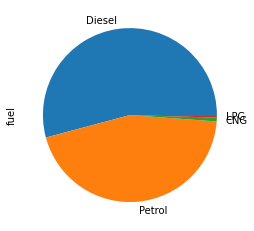

In [7]:
cars["fuel"].value_counts(normalize=True).plot(kind='pie')

<AxesSubplot:ylabel='seller_type'>

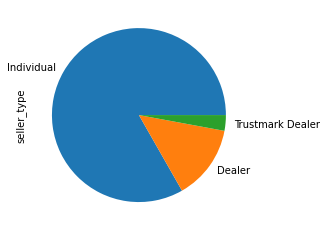

In [8]:
cars["seller_type"].value_counts(normalize=True).plot(kind='pie')

<AxesSubplot:ylabel='transmission'>

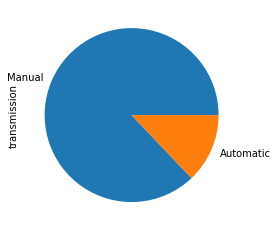

In [9]:
cars["transmission"].value_counts(normalize=True).plot(kind='pie')

<AxesSubplot:ylabel='owner'>

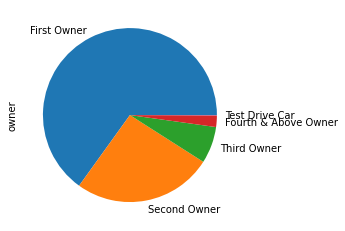

In [10]:
cars["owner"].value_counts(normalize=True).plot(kind='pie')

**On visualise la proportion en chiffres cette fois des valeurs dans les attributs catégoriels qui nous interéssent particulièrement :**

In [11]:
for col in ['seller_type','transmission','fuel', 'owner']:
    print(cars[col].value_counts()/cars.shape[0],'\n')

Individual          0.832431
Dealer              0.138533
Trustmark Dealer    0.029035
Name: seller_type, dtype: float64 

Manual       0.870817
Automatic    0.129183
Name: transmission, dtype: float64 

Diesel    0.541585
Petrol    0.446727
CNG       0.007013
LPG       0.004675
Name: fuel, dtype: float64 

First Owner             0.650714
Second Owner            0.258981
Third Owner             0.068282
Fourth & Above Owner    0.021407
Test Drive Car          0.000615
Name: owner, dtype: float64 



## Preprocessing

On convertit les roupies du dataset en euros, et l'année en âge afin d'avoir une meilleure compréhension des données.

In [12]:
def rupees_to_euros(elem):
    return elem*0.01211

def annee_to_age(elem):
    return 2022-elem

cars['selling_price'] = cars['selling_price'].apply(rupees_to_euros)
cars['year'] = cars['year'].apply(annee_to_age)
cars.rename(columns = {'year':'age'}, inplace = True)

On supprime les null puis on reset les index pour qu'ils s'adaptent.

In [13]:
cars = cars.dropna()
cars = cars.reset_index(drop=True) 

On remarque bien qu'il n'y a plus de valeur null.

In [14]:
cars.isnull().sum() 

name             0
age              0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

On supprime certains attributs : name a une faible corrélation avec le prix, torque est difficilement lisible et seats a également une faible corrélation avec le prix, nous pouvons donc nous en débarasser .

In [15]:
cars = cars.drop(['torque','name'],axis=1)

Ici nous supprimons les valeurs LPG et CNG pour l'attribut de fuel, Trustmark Dealer pour l'attribut de seller_type, Third Owner, Fourth  & Above Owner et Test Drive pour l'attribut owner, cela nous permet par la suite de les encoder binairement.

In [16]:
cars = cars.drop(cars[cars.fuel == 'LPG'].index)
cars = cars.drop(cars[cars.fuel == 'CNG'].index)
cars = cars.drop(cars[cars.seller_type == 'Trustmark Dealer'].index)
cars = cars.drop(cars[cars.owner == 'Third Owner'].index)
cars = cars.drop(cars[cars.owner == 'Fourth & Above Owner'].index)
cars = cars.drop(cars[cars.owner == 'Test Drive Car'].index)

cars = cars.reset_index(drop=True) 

Ici nous utilisons la fonction que nous avons définie dans le fichier utilities.py, supprimer_unit pour ne garder que la valeur numérique des attributs cités

In [17]:
supprimer_unit(cars,'max_power','bhp')

In [18]:
supprimer_unit(cars,'mileage', 'kmpl')

In [19]:
supprimer_unit(cars,'engine', 'CC')

Ensuite, on décide de supprimer les prix qui nous paraissent aberrants, au-delà de 60000 euros.

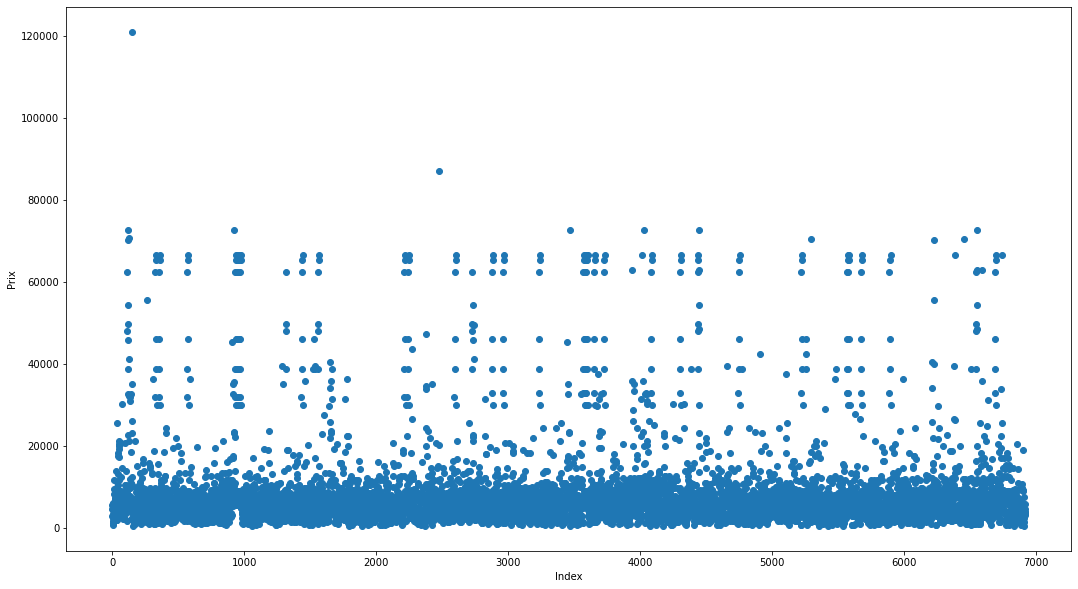

In [20]:
def affichage_prix_suppr(df,limite):
    fig, ax = plt.subplots(figsize = (18,10))
    ax.scatter(cars.index,df['selling_price'])
    ax.set_xlabel('Index')
    ax.set_ylabel('Prix')
    plt.show()
    df = df[df['selling_price']<limite] 
    
affichage_prix_suppr(cars,60000)

On s'occupe ici du déséquilibre pour les attributs seller_type, transmission, fuel, owner, pour cela on trie tout d'abord par owner en commençant par la valeur 1, car le 0 est majoritaire, puis on trie en fonction de seller_type et transmission en affichant les 0 en premier classiquement, puisqu'on supprime (en commençant par le bas toujours) par la suite les lignes avec les 1 qui sont majoritaires. On peut observer juste après que l'équilibre entre les différents attributs catégoriels s'est bien fait.

In [21]:
cars.sort_values(by=['owner'],ascending=False,inplace=True)
cars.sort_values(by=['seller_type','transmission'],inplace=True)
cars.drop(cars.index[2000:7582], axis=0,inplace=True)

def affichage_proportions(cols):    
    for col in cols:
        print(cars[col].value_counts()/cars.shape[0],'\n')
        
affichage_proportions(['seller_type','transmission','fuel','owner'])

Dealer        0.5485
Individual    0.4515
Name: seller_type, dtype: float64 

Manual       0.544
Automatic    0.456
Name: transmission, dtype: float64 

Diesel    0.5975
Petrol    0.4025
Name: fuel, dtype: float64 

First Owner     0.68
Second Owner    0.32
Name: owner, dtype: float64 



Ici nous nous occupons de la partie encodage, les 4 attributs cités sont transformés en one hot vectors, car ils ne peuvent pas être transformés binairement en ayant du sens étant donné que ce sont des chaines de caractères qui n'expriment pas une valeur supérieure/inférieure objective. 

In [22]:
cols = ['fuel','seller_type','transmission','owner']
cars = pd.get_dummies(cars,columns=cols)
cars

,age,selling_price,km_driven,mileage,engine,max_power,seats,fuel_Diesel,fuel_Petrol,seller_type_Dealer,seller_type_Individual,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Second Owner
4562,10,11201.75,96000,19.62,1998,190.00,5.0,1,0,1,0,1,0,0,1
2375,7,19981.50,91000,12.55,2982,168.50,7.0,1,0,1,0,1,0,0,1
2831,8,6660.50,31000,17.21,1197,103.60,5.0,0,1,1,0,1,0,0,1
5077,9,5485.83,54327,17.20,1197,103.60,5.0,0,1,1,0,1,0,0,1
5318,7,19981.50,91000,12.55,2982,168.50,7.0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,11,3875.20,70000,21.90,1396,90.00,5.0,1,0,0,1,0,1,0,1
1491,7,4238.50,50000,20.51,998,67.04,5.0,0,1,0,1,0,1,0,1
1490,8,3935.75,90000,23.20,1248,73.94,5.0,1,0,0,1,0,1,0,1
1488,22,544.95,50000,16.10,796,37.00,4.0,0,1,0,1,0,1,0,1


## Matrice de corrélation  :

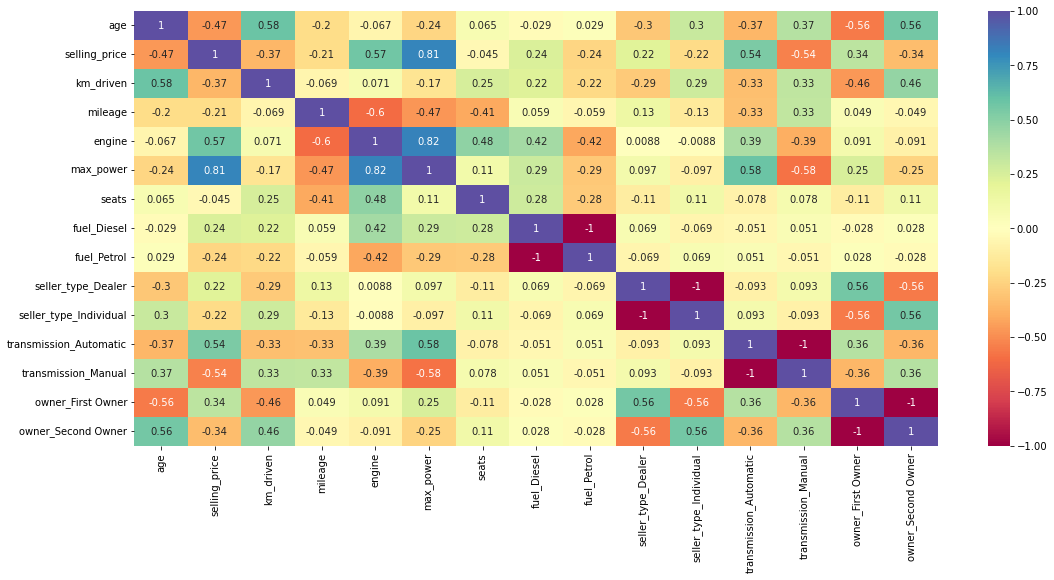

In [23]:
def affiche_matrice_correlation(dimx,dimy):
    plt.figure(figsize=(dimx,dimy))
    sns.heatmap(cars.corr(),annot=True,cmap= 'Spectral')
    plt.show()

affiche_matrice_correlation(18,8)

On supprime l'attribut seats qui a une faible corrélation avec le prix comme nous le voyons juste en haut, nous pouvons donc nous en débarasser .

In [24]:
cars = cars.drop(['seats'],axis=1)

## Division Train / Test

Et on passe à la division en Train et Test afin de recourir aux modèles par la suite.

In [25]:
X = cars[['age','km_driven','mileage','engine','max_power','fuel_Diesel','fuel_Petrol','seller_type_Dealer','seller_type_Individual','transmission_Automatic','transmission_Manual','owner_First Owner','owner_Second Owner']]
y = cars['selling_price'] # variable de prédiction

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42) # on stocke dans des valeurs de sortie, random_state pour éviter que ça ne change


## Modèles

Modèle de la régression linéaire, nous avons l'ordonnée à l'origine et les coefficients de l'équation permettant de déterminer le prix d'une voiture. <br>
Nous en avons aussi déduit un taux de variation entre le prix attendu et le prix prédit, cela nous a également permis de réaliser un graphe.

Ordonnée à l'origine :  -9945.133056883846
Coefficients:
[('age', -942.5976379146655), ('km_driven', -0.044161948281940394), ('mileage', 326.66807060085233), ('engine', -3.104473462672444), ('max_power', 283.14751559803705), ('fuel_Diesel', 751.5042073198845), ('fuel_Petrol', -751.5042073198647), ('seller_type_Dealer', 1372.8862648136655), ('seller_type_Individual', -1372.8862648136717), ('transmission_Automatic', 875.3561162843242), ('transmission_Manual', -875.3561162843133), ('owner_First Owner', -1357.4054985337496), ('owner_Second Owner', 1357.4054985337505)] 

Mean Absolute Error: 5424.013199966787
Mean Squared Error: 61112133.97295874
Root Mean Squared Error: 7817.425021895557
Model Score:  0.7653130190045758


,Prix attendu,Prix prédit,Taux de variation
5961,7629.30,9490.957848,24.401424
3577,66605.00,41580.132189,-37.572056
5815,9082.50,8157.900670,-10.180009
130,6478.85,11327.976783,74.845486
6735,6539.40,10548.465283,61.306317


Text(0, 0.5, 'Prédiction du modele')

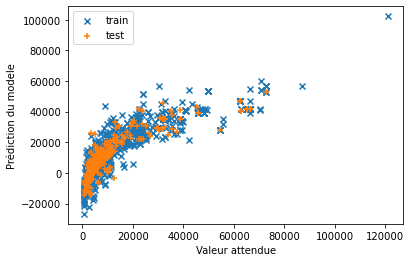

In [26]:
def regression_lineaire():
    regression = LinearRegression()  
    regression.fit(X_train, y_train)

    print("Ordonnée à l'origine : ", regression.intercept_)
    print("Coefficients:")
    print(list(zip(X_train, regression.coef_)) ,'\n')


    y_pred= regression.predict(X_test)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Model Score: ', regression.score(X_test,y_test))

    regression_diff = pd.DataFrame({'Prix attendu': y_test, 'Prix prédit': y_pred, 'Taux de variation' : ((y_pred-y_test)/y_test)*100})

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    display(regression_diff.head())


    y_train_pred = regression.predict(X_train)

    fig = plt.figure(1)
    plt.scatter(y_train, y_train_pred, marker='x', label='train')
    plt.scatter(y_test , y_pred , marker='+', label='test')

regression_lineaire()    
    
plt.legend()
plt.xlabel('Valeur attendue')
plt.ylabel('Prédiction du modele')

Modèle de forêt d'arbres décisitionnels, on remarque qu'il affiche un meilleur score, cela se voit clairement sur le graphe où les données sont affichées sous une forme linéaire car les prédictions sont justes.

## Modèle polynomial

Ici le modèle nécessite un hyper-paramètre qui est le degré du polynôme.

Mean Absolute Error: 3030.1772164099943
Mean Squared Error: 20960103.058525182
Root Mean Squared Error: 4578.220512221445
Le score R2 est 0.9195075840366685


,Prix attendu,Prix prédit,Taux de variation
5961,7629.30,6754.496187,-11.466371
3577,66605.00,55212.913594,-17.103951
5815,9082.50,6678.755436,-26.465671
130,6478.85,6063.294838,-6.414027
6735,6539.40,8516.972263,30.240882


Text(0, 0.5, 'Prédiction du modele')

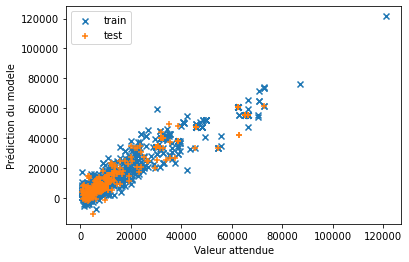

In [29]:
def regression_polynomiale():
    polynomial_features= PolynomialFeatures(degree=2)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.fit_transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_pred = model.predict(X_test_poly)
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Le score R2 est {}'.format(r2))
    model_diff = pd.DataFrame({'Prix attendu': y_test, 'Prix prédit': y_pred, 'Taux de variation' : ((y_pred-y_test)/y_test)*100})
    display(model_diff.head())
    fig = plt.figure(1)
    plt.scatter(y_train, y_train_pred, marker='x', label='train')
    plt.scatter(y_test , y_pred , marker='+', label='test')
    
regression_polynomiale()    
    
plt.legend()
plt.xlabel('Valeur attendue')
plt.ylabel('Prédiction du modele')